打印当前环境

In [2]:
import torch

print(torch.cuda.is_available())


True


下载训练数据和测试数据

In [3]:
import torchvision
train_data = torchvision.datasets.MNIST("./data",train = True,download = True,transform = torchvision.transforms.ToTensor())
test_data = torchvision.datasets.MNIST("./data",train = False,download = True,transform = torchvision.transforms.ToTensor())

train_data_size = len(train_data)
test_data_size = len(test_data)

print(train_data_size)
print(test_data_size)

60000
10000


加载训练数据和测试数据到内存

In [4]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_data,64)
test_dataloader = DataLoader(test_data,64)

打印数据结构

In [5]:
img,label = train_data[0]
print(img.shape)

torch.Size([1, 28, 28])


选择训练设备

In [10]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) 

cuda


创建神经网络(模型)

In [12]:
from torch import nn

#LeNet-1
class LeNet1(nn.Module):
    def __init__(self):
        super(LeNet1,self).__init__()
        self.conv1 = nn.Conv2d(1, 4, [5, 5])
        self.pool1 = nn.AvgPool2d([2, 2])
        self.conv2 = nn.Conv2d(4, 12, [5, 5])
        self.pool2 = nn.AvgPool2d([2, 2])
        self.fc1 = nn.Linear(12 * 4 * 4, 10)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = self.pool1(x)
        x = torch.tanh(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 12 * 4 * 4)
        x = self.fc1(x)

        return x

测试

In [13]:
input = torch.rand([28,28],dtype=torch.float32)
input = torch.reshape(input,[1,1,28,28])
net = LeNet1()
print(net)
output = net(input)
print(output) 

LeNet1(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0)
  (conv2): Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0)
  (fc1): Linear(in_features=192, out_features=10, bias=True)
)
tensor([[-0.0192, -0.1167,  0.0527, -0.0522,  0.0970, -0.0762,  0.0675,  0.1074,
          0.1014, -0.0814]], grad_fn=<AddmmBackward0>)


开始训练

In [21]:
from torch.utils.tensorboard import SummaryWriter
import time
net.to(device)
#损失函数
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)

learning_rate = 0.01  #1e-2 = 1*10^(-2)
#优化器
optimizer = torch.optim.SGD(net.parameters(),lr = learning_rate)

#设置训练网络的一些参数
#记录训练的次数
total_train_step = 0
#记录测试的次数
total_test_step = 0

#训练的轮数
epoch = 30

write = SummaryWriter("./logs_tran")

start_time = time.time()
for i in range(epoch):
    print("第{}轮训练开始".format(i+1))
    #训练步骤
    net.train()
    for data in train_dataloader:
        imgs ,targets = data
        imgs = imgs.to(device)
        targets = targets.to(device)
        output = net(imgs)
        loss = loss_fn(output,targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_step = total_train_step + 1
        if total_train_step % 100 == 0:
            end_time = time.time()
            print("训练100步花费的时间:{}".format(end_time-start_time))
            print("训练次数：{}，Loss：{}".format(total_train_step, loss.item()))
            write.add_scalar("train_loss",loss.item(),total_train_step)

    #测试步骤
    net.eval()
    total_test_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for data in test_dataloader:
            imgs, targets = data
            imgs = imgs.to(device)
            targets = targets.to(device)
            output = net(imgs)
            loss = loss_fn(output, targets)
            total_test_loss = total_test_loss + loss
            accuracy = (output.argmax(1) == targets).sum()
            total_accuracy = total_accuracy + accuracy

    print("整体测试集上面的Loss：{}".format(total_test_loss))
    print("整体测试集上的正确率：{}".format(total_accuracy/test_data_size))

    write.add_scalar("test_loss", total_test_loss, total_test_step)
    total_test_step = total_test_step + 1
    torch.save(net,"./models/net_{}.pth".format(i))

write.close()

第1轮训练开始
训练100步花费的时间:0.4851231575012207
训练次数：100，Loss：2.237673044204712
训练100步花费的时间:0.9335296154022217
训练次数：200，Loss：2.0555338859558105
训练100步花费的时间:1.358659029006958
训练次数：300，Loss：1.7290774583816528
训练100步花费的时间:1.7605030536651611
训练次数：400，Loss：1.22102952003479
训练100步花费的时间:2.1516976356506348
训练次数：500，Loss：0.992938220500946
训练100步花费的时间:2.563582181930542
训练次数：600，Loss：0.8611912131309509
训练100步花费的时间:2.978494644165039
训练次数：700，Loss：0.7035934925079346
训练100步花费的时间:3.3843653202056885
训练次数：800，Loss：0.7907202243804932
训练100步花费的时间:3.8023056983947754
训练次数：900，Loss：0.5452596545219421
整体测试集上面的Loss：90.03790283203125
整体测试集上的正确率：0.857699990272522
第2轮训练开始
训练100步花费的时间:4.687955617904663
训练次数：1000，Loss：0.5023768544197083
训练100步花费的时间:5.042654037475586
训练次数：1100，Loss：0.41044509410858154
训练100步花费的时间:5.40626859664917
训练次数：1200，Loss：0.5616967678070068
训练100步花费的时间:5.758271932601929
训练次数：1300，Loss：0.47934970259666443
训练100步花费的时间:6.102845907211304
训练次数：1400，Loss：0.43413248658180237
训练100步花费的时间:6.442488431930542
训练次

使用训练结果测试

In [18]:
import cv2
import matplotlib.pyplot as plt

def display(img1):
  fig = plt.figure(figsize=(5, 5))
  plt.title('Input image', fontsize=16)
  plt.axis('off')
  plt.imshow(img1)

def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img 

预测的结果为：2


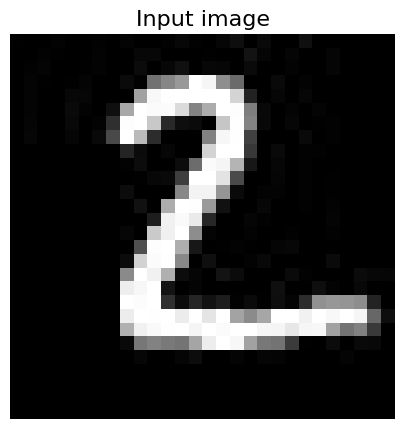

In [22]:
import torch
import torchvision
from PIL import Image

test_data = torchvision.datasets.MNIST("./data",train = False,download = True,transform = torchvision.transforms.ToTensor())

transform = torchvision.transforms.Compose([torchvision.transforms.Resize((28,28)),torchvision.transforms.ToTensor()])


image,label = test_data[1]


PIL_Imnage = torchvision.transforms.ToPILImage()

pic = PIL_Imnage(image)

pic.save("random.jpg")

img_path = imread("random.jpg")

display(img_path)

model = torch.load("./models/net_29.pth")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image = image.to(device)
model.eval()
with torch.no_grad():
    output = model(image)
print("预测的结果为：{}".format(output.argmax(1).item())) 